In [68]:
import pickle
from typing import List, Dict

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown
from evalify import Experiment
import numpy as np
from src.config.project_paths import get_data_file_path
from src.embedding.embedded_audio import EmbeddedAudio


In [6]:
embeddings_path = get_data_file_path("raw_audio_embeddings_speechbrain-spkrec-ecapa-voxceleb.pkl")

In [7]:
embeddings: List[EmbeddedAudio] = pickle.load(open(embeddings_path, "rb"))

In [8]:
annotations_path = get_data_file_path("annotations_with_metadata.json")

In [9]:
annotations = pd.read_json(annotations_path, orient="records")

In [50]:
annotations = annotations[annotations["set"] == "test"]

In [51]:
annotations.head()

,wav_path,user_id,split,user_name,gender,nationality,set
148642,data/vox1_test_wav/wav/id10277/tbh20gz_KRA/000...,id10277,test,Eduardo_Noriega,m,Spain,test
148643,data/vox1_test_wav/wav/id10277/tbh20gz_KRA/000...,id10277,test,Eduardo_Noriega,m,Spain,test
148644,data/vox1_test_wav/wav/id10277/tbh20gz_KRA/000...,id10277,test,Eduardo_Noriega,m,Spain,test
148645,data/vox1_test_wav/wav/id10277/tbh20gz_KRA/000...,id10277,test,Eduardo_Noriega,m,Spain,test
148646,data/vox1_test_wav/wav/id10277/tbh20gz_KRA/000...,id10277,test,Eduardo_Noriega,m,Spain,test


In [59]:
indexed_annotations = annotations.set_index("wav_path")
audio_path_to_data = indexed_annotations.to_dict(orient="index")

In [60]:
int_encoding: Dict[str, int] = {}
count = 0
for user_id in annotations["user_id"].unique():
    if user_id not in int_encoding.keys():
        int_encoding[user_id] = count
        count += 1

In [61]:
embeddings_X = []
user_y = []
for embedded_audio in embeddings:
    audio_data = audio_path_to_data.get(embedded_audio.audio_rel_path, None)
    if audio_data is None:
        continue
    user_id = audio_data["user_id"]
    user_id_int_encoding = int_encoding[user_id]
    embeddings_X.append(embedded_audio.embedding)
    user_y.append(user_id_int_encoding)


In [63]:
experiment = Experiment()
results = experiment.run(embeddings_X, user_y, metrics=["cosine_similarity"], batch_size=1000)

# Experiment results

In [64]:
eer = experiment.calculate_eer()


In [65]:
display(Markdown("### Cosine Similarity"))
display(
    Markdown(f"* EER: {eer['cosine_similarity']['EER']:.4f} @ Threshold {eer['cosine_similarity']['Threshold']:.4f}"))

### Cosine Similarity

* EER: 0.0077 @ Threshold 0.2594

In [72]:
threshold_results = {}
for threshold in np.linspace(0, 1, num=50, endpoint=False):
    threshold_results[threshold] = experiment.evaluate_at_threshold(threshold, "cosine_similarity")

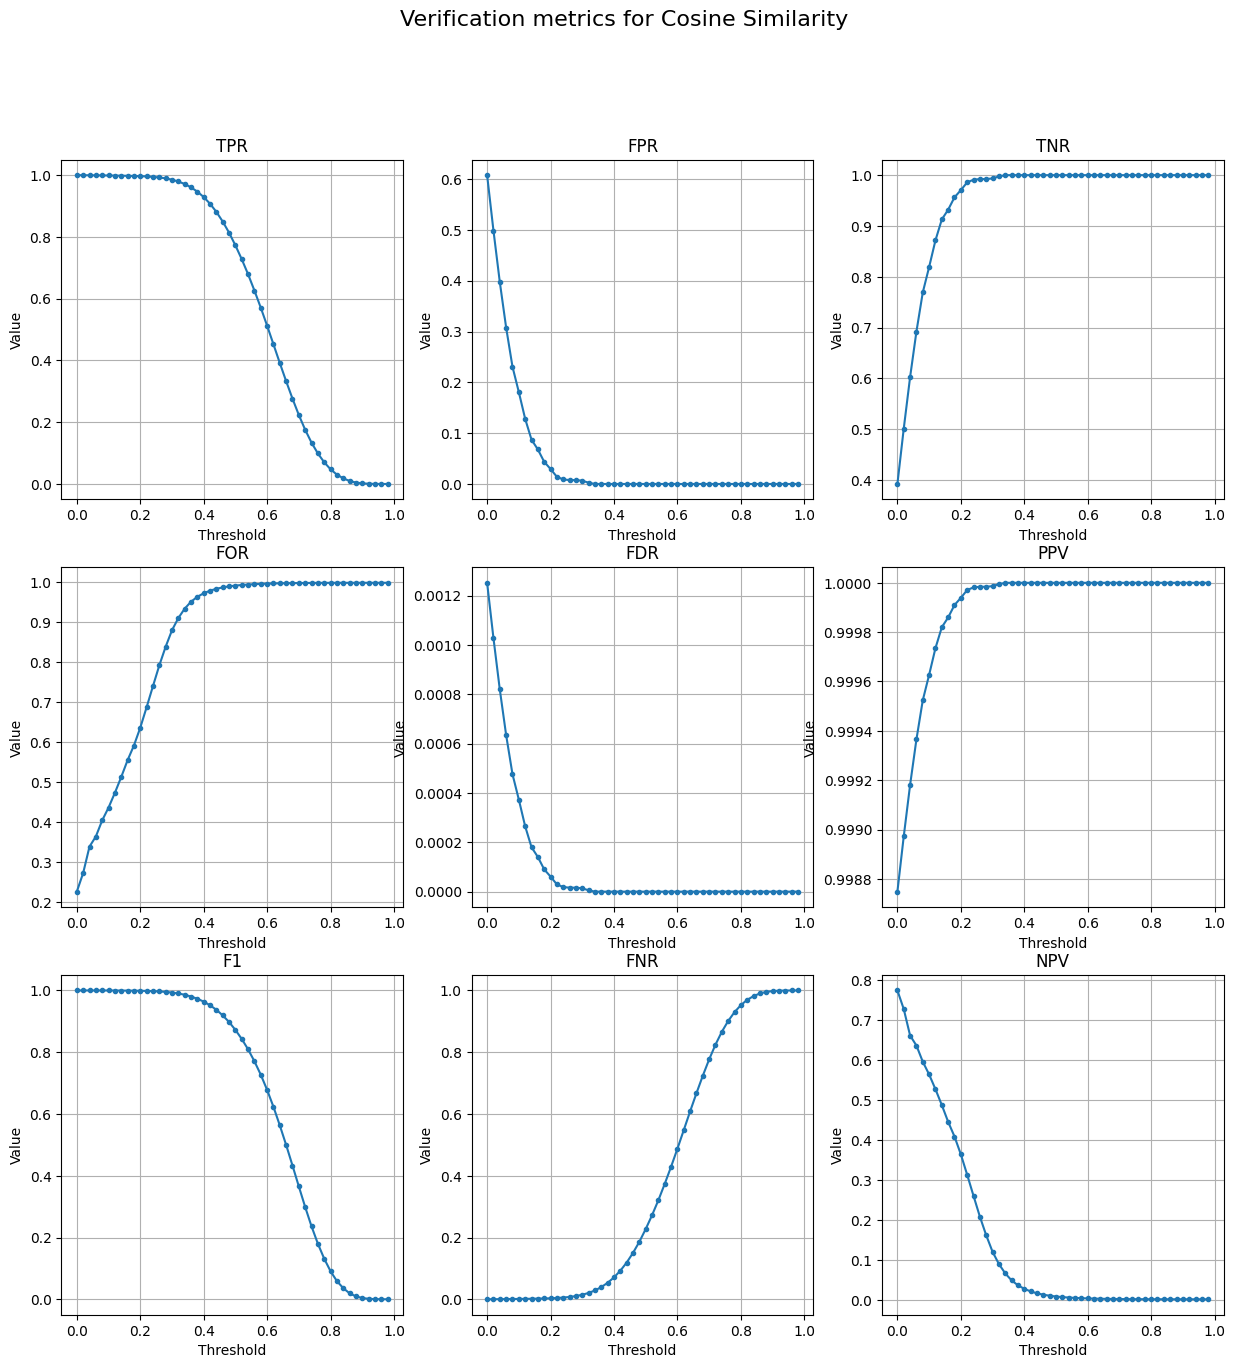

In [76]:
metrics = set()
for details in threshold_results.values():
    metrics.update(details.keys())

rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))  # Adjust size as needed
axes = axes.flatten()  # Flatten the array of axes
fig.suptitle("Verification metrics for Cosine Similarity", fontsize=16)

for i, metric in enumerate(metrics):
    thresholds = sorted(threshold_results.keys())  # Get a sorted list of thresholds
    values = [threshold_results[threshold][metric] for threshold in thresholds]

    ax = axes[i]
    ax.plot(thresholds, values, marker=".")
    ax.set_title(metric)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Value")
    ax.grid(True)